# EFAS - reservoir inflow
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 04-09-2024<br>

**Introduction:**<br>

This code extracts the discharge time series from the EFASv5 discharge reanalysis. It's simply a specific application of the tool `ncextract` in the `lisflood-utilities` repository. I had to do it because the tool returned errors reading some of the NetCDF files.

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

from reservoirs_lshm.utils import DatasetConfig
from reservoirs_lshm.utils.utils import upstream_pixel

### Configuration

In [9]:
# read dataset configuration file
cfg = DatasetConfig('config_dataset.yml')

# variable
var = 'dis'

# directory of the ResOpsES data set
PATH_AUX = cfg.PATH_RESOPS / 'ancillary' / 'ncextract'
PATH_OUT = PATH_AUX / var
PATH_OUT.mkdir(parents=True, exist_ok=True)

print(f'Extracted time series will be saved in {PATH_OUT}')

### Reservoirs

  0%|          | 0/1 [00:00<?, ?it/s]

305 reservoirs


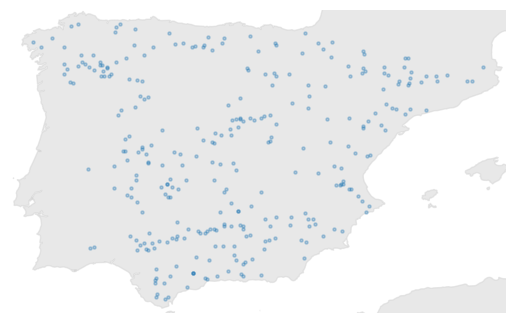

In [7]:
# import shapefile
resops = gpd.read_file(path_aux / 'reservoirs.shp')
resops[['LAT', 'LON']] = resops[['LAT', 'LON']].astype(float)
resops.set_index('SNCZI', drop=True, inplace=True)

# load map of upstream area
fac = xr.open_dataset(cfg.PATH_LISFLOOD / 'iberia' / 'maps' / 'upArea_iberian_01min.nc')['Band1']

# load EFAS attributes
attr_EFAS = pd.read_csv(cfg.PATH_ATTRS / 'efas.csv', index_col='GRAND_ID')

# search upstream pixel for EFAS reservoirs
for ID in tqdm(attr_EFAS.index.intersection(resops.index)):
    resops.loc[ID, ['LAT', 'LON']] = upstream_pixel(*resops.loc[ID, ['LAT', 'LON']], upArea=fac)

# convert to DataArray of point coordinates
points = resops[['LAT', 'LON']].to_xarray()
n_reservoirs = len(points.LAT)
print(f'{n_reservoirs} reservoirs')

# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
ax.scatter(points.LON, points.LAT, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

### Time series of reservoir storage

In [8]:
# read
path_ts = cfg.PATH_LISFLOOD / 'iberia' / 'reanalysis'
ds = xr.open_mfdataset(f'{path_ts}/{var}_*.nc', chunks='auto', parallel=True)

# I substract 12 hours from the original 'time' dimension
# 1. 6 h because we discovered an error in the storage of the EFAS data in the Climate Data Store
# 2. 6 h to convert the end-of-timestep convention into start-of timestep, so I can apply `resample`
ds['time'] = ds['time'] - pd.Timedelta(hours=12)

# resample to daily resolution
ds = ds.resample(time='1D').mean()

# extract points of interest
ds_poi = ds.sel(lat=points.LAT, lon=points.LON, method='nearest').compute()

OSError: no files to open

In [ ]:
# export
for ID in tqdm(ds_poi.SNCZI.data):
    fileout = PATH_OUT / f'{ID:04}.nc'
    if fileout.exists():
        continue
    ds_poi.sel(SNCZI=ID).to_netcdf(fileout)